In [20]:
import os
import glob
import cv2

import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, AveragePooling2D, ReLU, LeakyReLU, Softmax
from tensorflow.python.keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import imghdr
import imagesize
from PIL import Image

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn

%config Completer.use_jedi = False

In [21]:
data_generator = ImageDataGenerator(rescale=1./255)
test1_data_256 = data_generator.flow_from_directory('images_v2_for_data_augmentation\\test',
                           target_size=(256, 256),
                           batch_size=16,
                           shuffle=False,
                          class_mode='sparse')
test1_data_128 = data_generator.flow_from_directory('images_v2_for_data_augmentation\\test',
                           target_size=(128, 128),
                           batch_size=16,
                           shuffle=False,
                          class_mode='sparse')

Found 1616 images belonging to 3 classes.
Found 1616 images belonging to 3 classes.


In [22]:
data_generator = ImageDataGenerator(rescale=1./255)
test2_data_256 = data_generator.flow_from_directory('test_images_v2',
                           target_size=(256, 256),
                           batch_size=16,
                           shuffle=False,
                          class_mode='sparse')
test2_data_128 = data_generator.flow_from_directory('test_images_v2',
                           target_size=(128, 128),
                           batch_size=16,
                           shuffle=False,
                          class_mode='sparse')

Found 60 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [23]:
from fnmatch import fnmatch
def load_models(directory):
    model_paths, models = [], []
    for path, subdirs, files in os.walk(directory):
        for name in files:
            if fnmatch(name, "*.h5"):
                model_path = os.path.join(path, name)
                print(model_path)
                model_paths.append(model_path)
                model = tf.keras.models.load_model(model_path, compile=False)
                model.compile()
                models.append(model)
    return model_paths, models

In [24]:
model_paths, models = [], []
for directory in ["with_augmented_data", "model_optimalisation"]:
    model_paths_temp, models_temp = load_models('saved_models/' + directory)
    model_paths.extend(model_paths_temp)
    models.extend(models_temp)

saved_models/with_augmented_data\Base with extended dataset.h5
saved_models/with_augmented_data\Base.h5
saved_models/with_augmented_data\Big filters.h5
saved_models/with_augmented_data\Reduced filters.h5
saved_models/with_augmented_data\VGG19 inspired.h5
saved_models/model_optimalisation\2Conv-64-32-DO05.h5
saved_models/model_optimalisation\3Conv-64-DO05-32-DO05-16-LR01.h5
saved_models/model_optimalisation\3Conv-64-DO05-32-DO05-16-LR03.h5
saved_models/model_optimalisation\Base.h5
saved_models/model_optimalisation\LR Best.h5


In [25]:
def evaluate_models(data_256, data_128):
    global model_paths, models
    
    evaluations = []
    for model in models:
        config = model.get_config()
        width, height = list(config["layers"][0]["config"]["batch_input_shape"])[1:3]
        evaluation = []
        if width == 256:
            predictions = model.predict(x=data_256, steps=len(data_256), verbose=0)
            evaluation = model.evaluate(x=data_256)
        elif width == 128:
            predictions = model.predict(x=data_128, steps=len(data_128), verbose=0)
            evaluation = model.evaluate(x=data_128)        
        evaluations.append(evaluation)
    return evaluations

In [26]:
def get_cm_all(data_256, data_128):
    global model_paths, models
    i = 0
    cms = []
    for model in models:
        config = model.get_config()
        width, height = list(config["layers"][0]["config"]["batch_input_shape"])[1:3]
        if width == 256:
            y_prediction = model.predict(data_256)
        elif width == 128:
            y_prediction = model.predict(data_128)

        y_prediction_argmax = np.argmax(y_prediction, axis=1)
        
        accuracy = accuracy_score(data_256.classes, y_prediction_argmax)
        accuracy = round(accuracy, ndigits=3)
        result = confusion_matrix(data_256.classes, y_prediction_argmax)
            
        dataframe_cm = pd.DataFrame(result, index = [label for label in ["animal", "car", "human"]],
                          columns = [label for label in ["animal", "car", "human"]])
        plt.figure(figsize = (4,4))
        plt.figtext(0.28, -0.02, f"Accuracy: {accuracy}", fontsize=14)
        ax = plt.axes()
        cm = sn.heatmap(dataframe_cm, annot=True, fmt='g', ax=ax)
        ax.set_title(model_paths[i])
        cms.append(cm)

        i = i + 1
    return cms

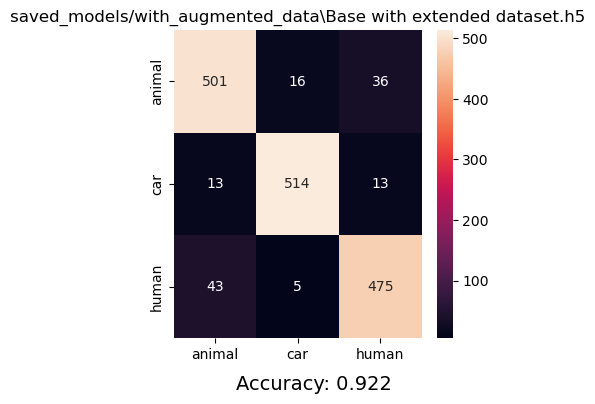

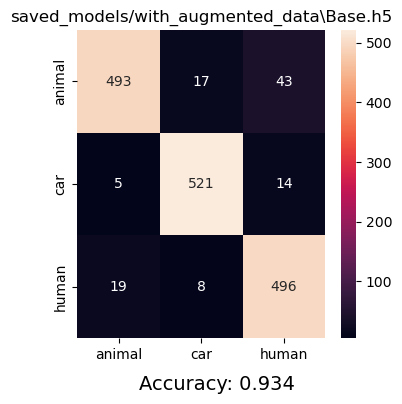

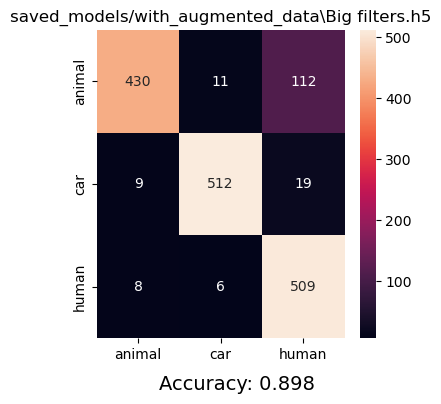

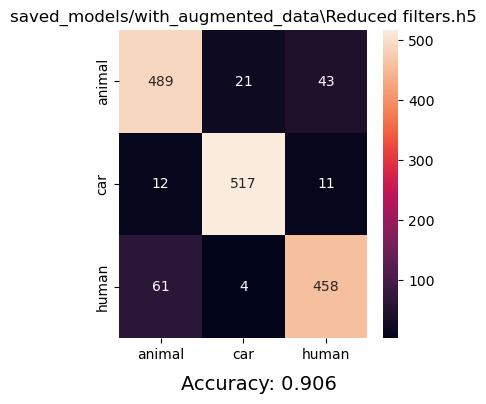

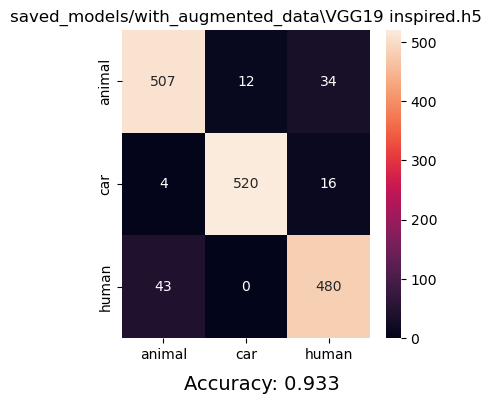

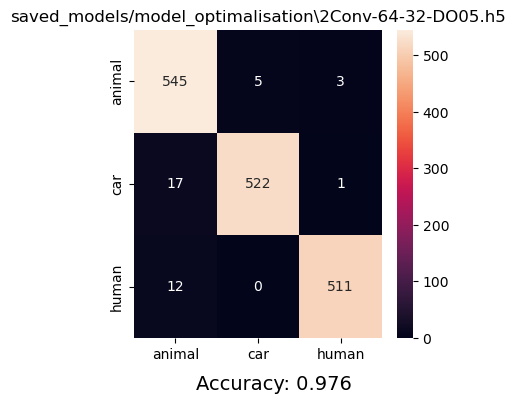

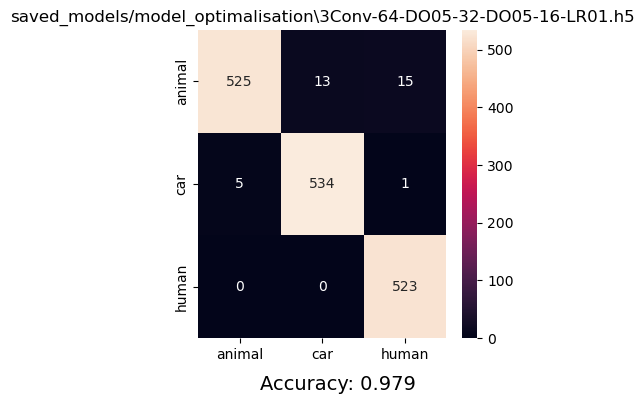

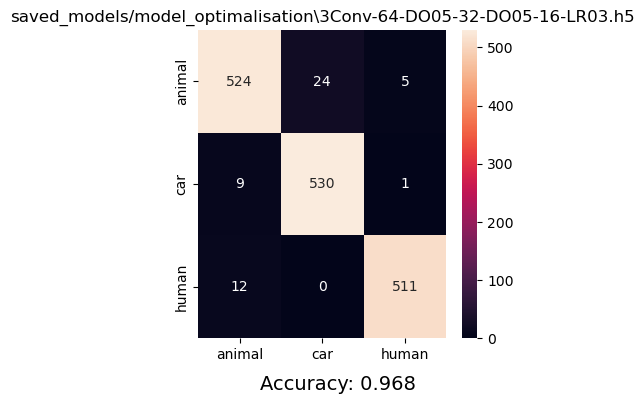

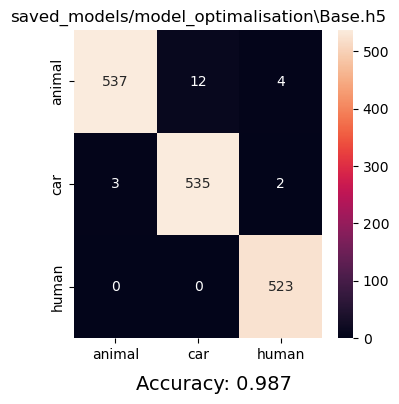

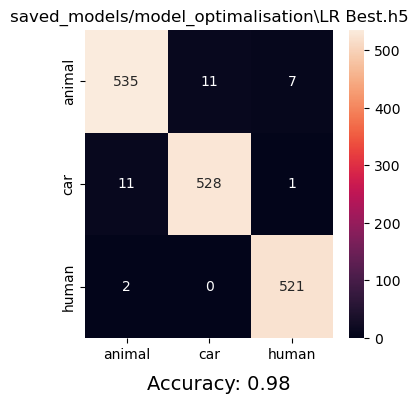

In [27]:
cms = get_cm_all(test1_data_256, test1_data_128)

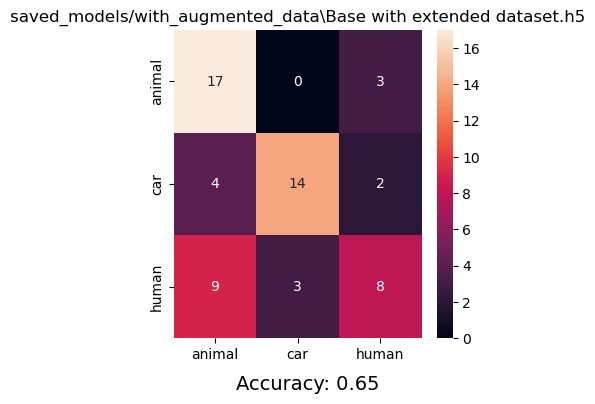

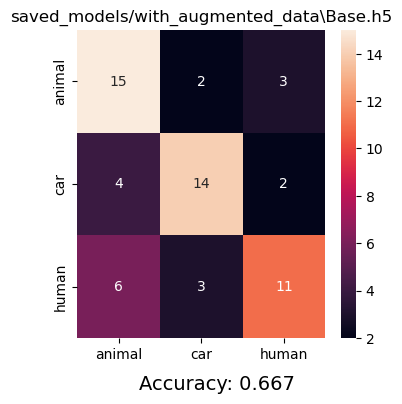

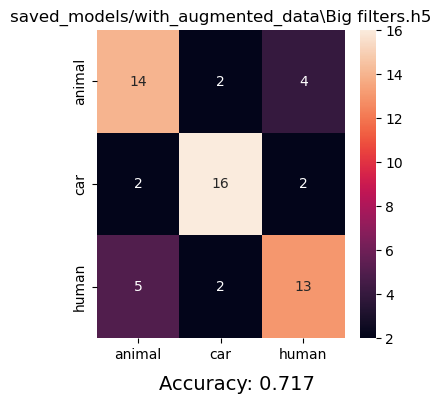

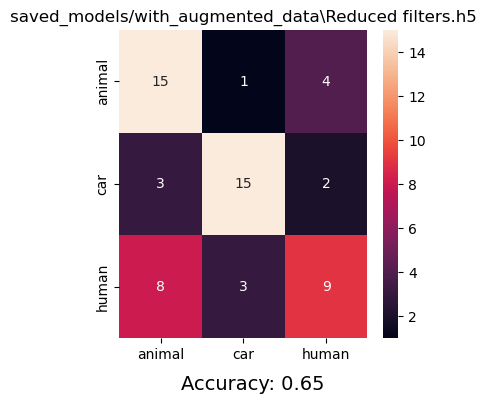

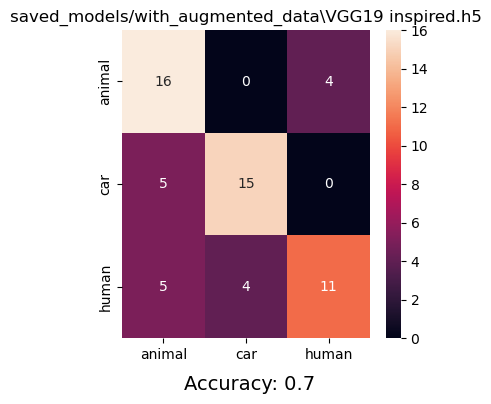

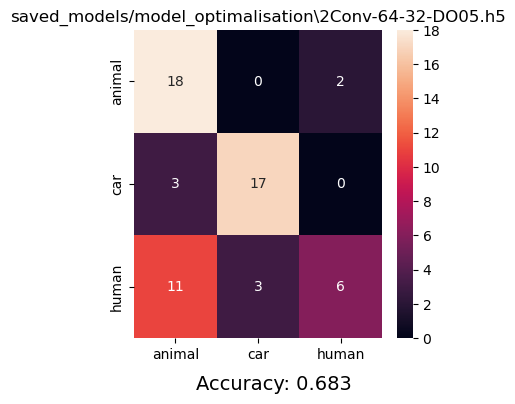

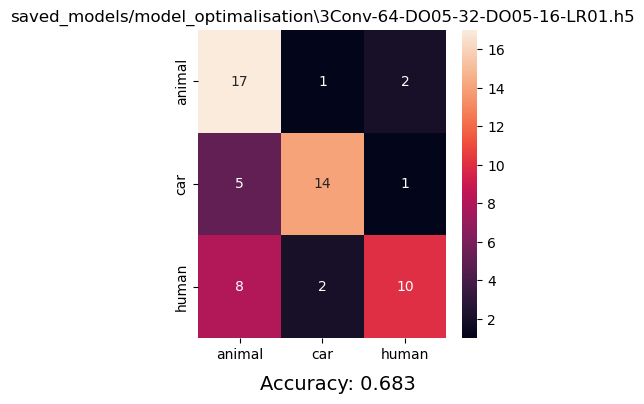

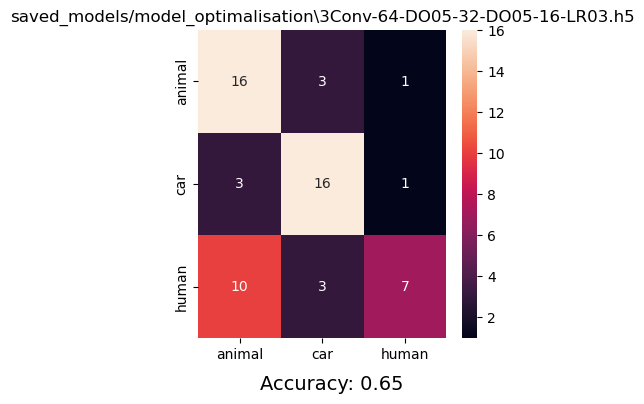

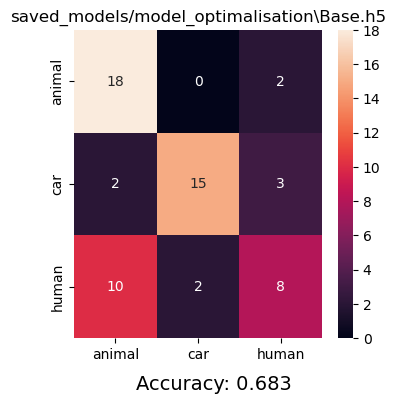

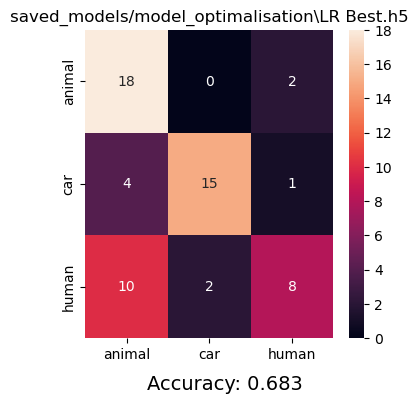

In [28]:
cms = get_cm_all(test2_data_256, test2_data_128)